<a href="https://colab.research.google.com/github/Car27VeP/Customer_Churn_Prediction/blob/main/Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso Práctico.

DRM ha contratado a Accenture para la actualización de su modelo de riesgo de incumplimiento con el objetivo de cumplir con la regulación mexicana y optimizar la rentabilidad reduciendo la tasa de incumplimiento.

Tareas:

- Hacer un EDA para analizar, etender y preprocesar datos.
- Proporner 5 modelos de machine laerning.
- Escoger el modelo con mejor exactitud (accuracy).


La notebook se divide en dos partes:

I. Análisis Exploratiro de Datos:
*   Importar Lirerías.
*   Carga de datos.
*   Información generla de los datos.
*   Juntar los datasets.
*   Visualición de los datos.
*   Correlación

II. Aplicación de Modelos.
*   Regresión Logística
*   Árboles de Decisión
*   Bosques Aleatorios
*   Catboost
*   XGBoost
*   Redes neuronales


Nombre las columnas:

- **customerID**: Customer ID
- **gender**: Customer's gender (Male, Female)
- **SeniorCitizen**: Whether the customer is a senior citizen (1 = Yes, 0 = No)
- **Partner**: Whether the customer has a partner (Yes, No)
- **Dependents**: Whether the customer has dependents (Yes, No)
- **Tenure**: Number of months the customer has stayed with the company
- **PhoneService**: Whether the customer has a phone service (Yes, No)
- **MultipleLines**: Whether the customer has multiple lines (Yes, No, No phone service)
- **InternetService**: Internet service provider (DSL, Fiber optic, No)
- **OnlineSecurity**: Whether the customer has online security (Yes, No, No internet service)
- **OnlineBackup**: Whether the customer has online backup (Yes, No, No internet service)
- **DeviceProtection**: Whether the customer has device protection (Yes, No, No internet service)
- **TechSupport**: Whether the customer has tech support (Yes, No, No internet service)
- **StreamingTV**: Whether the customer has streaming TV (Yes, No, No internet service)
- **StreamingMovies**: Whether the customer has streaming movies (Yes, No, No internet service)
- **Contract**: Customer's contract term (Month-to-month, One year, Two year)
- **PaperlessBilling**: Whether the customer has paperless billing (Yes, No)
- **PaymentMethod**: Customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
- **MonthlyCharges**: Monthly charge to the customer
- **TotalCharges**: Total charges to the customer
- **Churn**: Whether the customer churned (Yes or No)



# Parte I. Análisis Exploratorio de Datos.

## Paso 0. Importar Librerías.

In [ ]:
import importlib.util

package_name = "catboost"
spec = importlib.util.find_spec(package_name)

if spec is None:
    print(f"El paquete '{package_name}' NO está instalado.")
    print(f"Instalación en proceso.....")
    !pip install catboost
else:
    print(f"El paquete '{package_name}' está instalado.")

El paquete 'catboost' está instalado.


In [ ]:
# Standard Library
import math
from scipy.stats import chi2_contingency

# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score

# Other ML Libraries
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Deep Learning Framework
from tensorflow import keras


## Paso 1. Carga de datos.

El archivo proporcionado es un Excel que contiene tres hojas de cálculo con diferentes datos de clientes, como su ID, el monto que pagan mensualmente, los tipos de servicios de internet que tienen, entre otros. Vamos a extraer cada una de estas hojas en un DataFrame de pandas.

El método correcto para esto es `read_excel` con el parametro `sheet_name` de la librería pandas.

In [ ]:
df_charges = pd.read_excel("Data.xlsx", sheet_name="Charges")
df_services = pd.read_excel("Data.xlsx", sheet_name="Other data")
df_churn = pd.read_excel("Data.xlsx", sheet_name="Churn")

In [ ]:
df_charges.head()

,customerID,MonthlyCharges,TotalCharges
0,7590-VHVEG,29.85,29.85
1,5575-GNVDE,56.95,1889.5
2,3668-QPYBK,53.85,108.15
3,7795-CFOCW,42.30,1840.75
4,9237-HQITU,70.70,151.65


El dataframe df_charges tiene información relevenate como el ID del cleinte, el monto mensual y monto total.

In [ ]:
df_services.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic)
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check


El dataframe services contiene información sobre el cliente (género, estado civil, meses activo con el servicio), así como si tiene servicios adicionales, tipos de contrato y método de pago.

In [ ]:
df_churn.head()

,customerID,Churn
0,7590-VHVEG,Yes
1,5575-GNVDE,Yes
2,3668-QPYBK,Yes
3,7795-CFOCW,Yes
4,9237-HQITU,Yes


El archivo excel proporcionado incluye tres hojas que corresponden a `Charges`, `Other data` y `Churn` que se dividieron en tres datasets. ***df_charges***, ***df_services*** y ***df_churn*** respectivamente.

## Paso 2. Información general de los datos.

### Paso 2.1. Tratando con Charges.

In [ ]:
df_charges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customerID      7043 non-null   object 
 1   MonthlyCharges  7036 non-null   float64
 2   TotalCharges    7023 non-null   object 
dtypes: float64(1), object(2)
memory usage: 165.2+ KB


El dataset charges contiene 7043 registros y 3 columnas. La primera representa el ID del cliente, la segunda el cargo mensual del cliente y la última el cargo total al cliente.
Ya que las columnas `TotalCharges` y `TotalCharges` tienen pocos valores nulos, podemos descartarlos. Además los tipos de valores de la columa `TotalCharges` lo podemos convertir a `float_64`. Antes de convertila de `object` a `float64`, tenemos que sustuir todo aquella cadena a vacía a str('0').

#### Paso 2.1.1 Descartar valores nulos.

In [ ]:
df_charges = df_charges.dropna()

#### Paso 2.1.2 Reemplazar cadenas vacías a 0 y cambiar el tipo de valor a float64.

In [ ]:
df_charges.loc[:,'TotalCharges'] = df_charges.loc[:,'TotalCharges'].replace(' ', '0')
df_charges['TotalCharges'] = df_charges['TotalCharges'].astype('float64')

<ipython-input-9-e1222003d379>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_charges['TotalCharges'] = df_charges['TotalCharges'].astype('float64')


#### Paso 2.1.3 Descripción estadística general.

In [ ]:
df_charges.describe()

,MonthlyCharges,TotalCharges
count,7016.000000,7016.000000
mean,64.766940,2278.931257
std,30.078708,2266.592884
min,18.250000,0.000000
25%,35.587500,395.975000
50%,70.350000,1392.925000
75%,89.850000,3785.300000
max,118.750000,8684.800000


Observando la descripción general de los datos, podemos apreciar que en la columna `MonthlyCharges` hay un sesgo a la derecha y en al columna `TotalCharges`, un sesgo a la izquierda. Además hay valor mínimo que es cero.

Observemos los clientes que tinen valores en cero en la columna `TotalCharges`.

In [ ]:
df_charges.query("TotalCharges == 0")

,customerID,MonthlyCharges,TotalCharges
488,4472-LVYGI,52.55,0.0
753,3115-CZMZD,20.25,0.0
936,5709-LVOEQ,80.85,0.0
1082,4367-NUYAO,25.75,0.0
1340,1371-DWPAZ,56.05,0.0
3331,7644-OMVMY,19.85,0.0
3826,3213-VVOLG,25.35,0.0
4380,2520-SGTTA,20.00,0.0
5218,2923-ARZLG,19.70,0.0
6670,4075-WKNIU,73.35,0.0


Recrodemos que estos datos los obtuvimos del paso 2.2. Como no estamos seguros del cargo total de estos clientes, procedemos a eliminarlos ya que cuentan como valores nulos.

#### Paso 2.1.4 Descartar los valors en cero.

In [ ]:
df_charges = df_charges.drop(df_charges.query("TotalCharges == 0").index).reset_index(drop=True)

In [ ]:
df_charges.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7005 entries, 0 to 7004
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customerID      7005 non-null   object 
 1   MonthlyCharges  7005 non-null   float64
 2   TotalCharges    7005 non-null   float64
dtypes: float64(2), object(1)
memory usage: 164.3+ KB


Eliminamos 30 valores nulos. Teniendo ahora 7005 registros.

#### Paso 2.1.5 Boxplot de `MonthlyCharges` y `TotalCharges`.

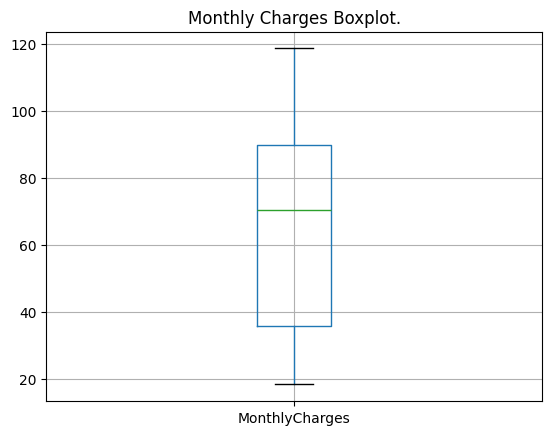

In [ ]:
df_charges.boxplot(column='MonthlyCharges')
plt.title("Monthly Charges Boxplot.")
plt.show()

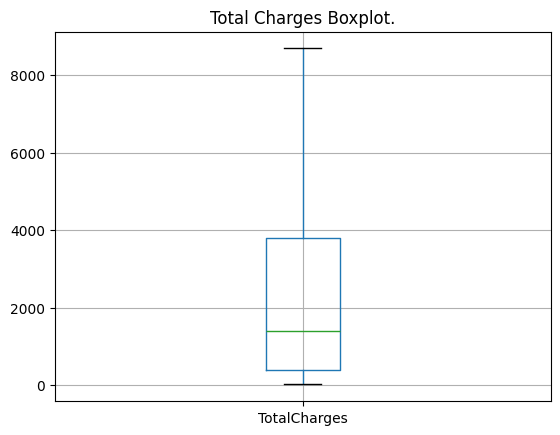

In [ ]:
df_charges.boxplot(column='TotalCharges')
plt.title("Total Charges Boxplot.")
plt.show()

#### Conclusión.
- Eliminamos valores nulos (NaN), espacios o cadenas vacías y ceros.
- Hay un sesgo a la derecha en la columna `MonthlyCharges` pero no hay outliers.
- Hay un sesgo a la izquierda en la columna `TotalCharges` pero no hya outliers.

### Paso 2.2 Tratando con Services

In [ ]:
df_services.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        7043 non-null   object
 1   gender            7043 non-null   object
 2   SeniorCitizen     7043 non-null   int64 
 3   Partner           7043 non-null   object
 4   Dependents        7043 non-null   object
 5   tenure            7043 non-null   int64 
 6   PhoneService      7043 non-null   object
 7   MultipleLines     7043 non-null   object
 8   InternetService   7043 non-null   object
 9   OnlineSecurity    7043 non-null   object
 10  OnlineBackup      7043 non-null   object
 11  DeviceProtection  7043 non-null   object
 12  TechSupport       7043 non-null   object
 13  StreamingTV       7043 non-null   object
 14  StreamingMovies   7043 non-null   object
 15  Contract          7043 non-null   object
 16  PaperlessBilling  7043 non-null   object
 17  PaymentMethod 

En este dataset no tenemos valores nulos. No es necesario aplicar nada más.

#### Paso 2.2.1. Descrpción estadística general.

In [ ]:
df_services.describe(include='all')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
count,7043,7043,7043.000000,7043,7043,7043.000000,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,7043,2,NaN,2,2,NaN,2,3,3,3,3,3,3,3,3,3,2,4
top,7590-VHVEG,Male,NaN,No,No,NaN,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,1,3555,NaN,3641,4933,NaN,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365
mean,NaN,NaN,0.162147,NaN,NaN,32.371149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.368612,NaN,NaN,24.559481,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,0.000000,NaN,NaN,9.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,0.000000,NaN,NaN,29.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,0.000000,NaN,NaN,55.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En el análisis descriptivo se observa que la distribución entre hombres y mujeres es casi proporcional. Además, la mayoría de los clientes no pertenecen a la tercera edad, no tienen pareja, son independientes y, en general, no han contratado servicios complementarios en sus paquetes. En promedio, tienen más de 32 meses como clientes desde su último registro. También se destaca que prefieren realizar pagos mensuales y a través de métodos electrónicos.

#### Conclusión.
- Las cantidad de cliente entre hombres y mujeres es casi proporcional.
- La mayoría de los clientes no pertenecen a la tercera edad, no tienen pareja, son independientes y no han contratado servicios complementarios en sus paquetes.
- En promedio, tienen más de 32 meses como clientes desde el último registro.
- Prefieren realizar pagos mensuales y en línea.

### Paso 2.3. Tratando con Churn.

In [ ]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7043 non-null   object
 1   Churn       7043 non-null   object
dtypes: object(2)
memory usage: 110.2+ KB


Tampoco tiene valores nulos.

#### Paso 2.3.1. Descripción estadística general.

In [ ]:
df_churn.describe()

,customerID,Churn
count,7043,7043
unique,7043,2
top,7590-VHVEG,Yes
freq,1,3542


La mitad de los clientes cancelaron los servicios.

#### Conclusión.

- No hay desbalance de clases.

## Paso 3. Juntar los 3 datasets.

Para fines más prácticos, juntaremos los 3 dataset para trbajar únicamnete en uno. Esto se hará con el método merge y cse unirán con el ID del cliente.

In [ ]:
df_all_together = pd.merge(pd.merge(df_charges, df_services, on='customerID'), df_churn, on='customerID')

In [ ]:
df_all_together.shape

(7005, 21)

#### Paso 3.1. Relaciones entre variables.

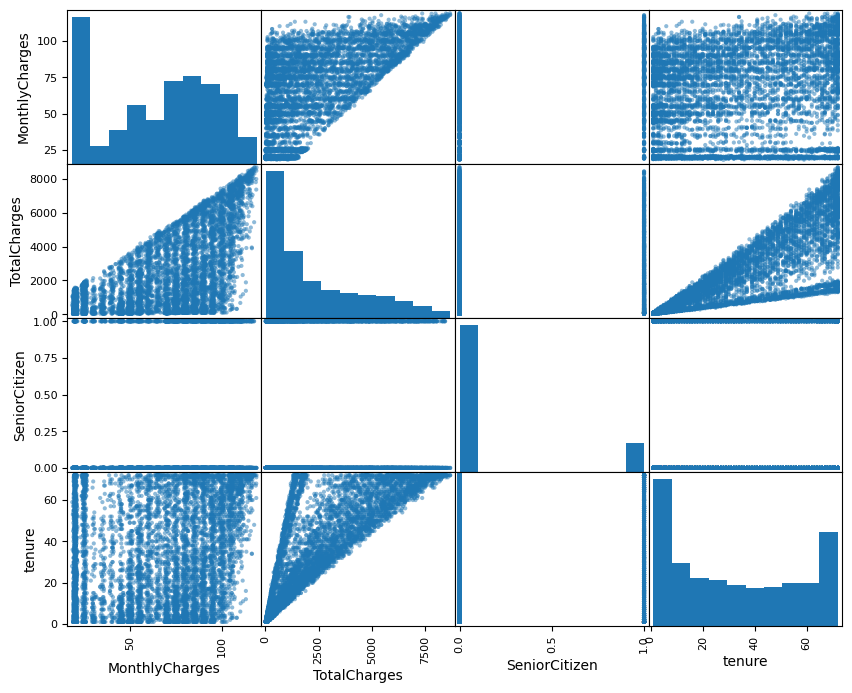

In [ ]:
pd.plotting.scatter_matrix(df_all_together, figsize=(10,8))
plt.show()

En el scatter matrix podemos observar que hay una relacion lineal con `tenure` y `TotalCharges` y  con `TotalCharges` y `MonhtlCharges`.

En la gráfica `tenure` y `TotalCharges`, entre más antiguo es el cliente más pagan. Podemos observar cuanto pagan en promedio los clientes senior.

### Paso 3.2 Observando `TotalCharges`.

Observaremos la descripción general y boxplot de los cargos totales agrupados por SeniorCitizen.

In [ ]:
df_all_together.groupby("SeniorCitizen")['TotalCharges'].describe()

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,,,,,,,,
0,5864.0,2180.407546,2233.279916,18.80,364.20,1294.60,3565.8875,8684.8
1,1141.0,2807.249649,2362.851396,19.45,688.65,2263.45,4599.1500,8443.7


El 83% de los usuarios no son senior y en promedio pagan 2180.40 de cargos totales.

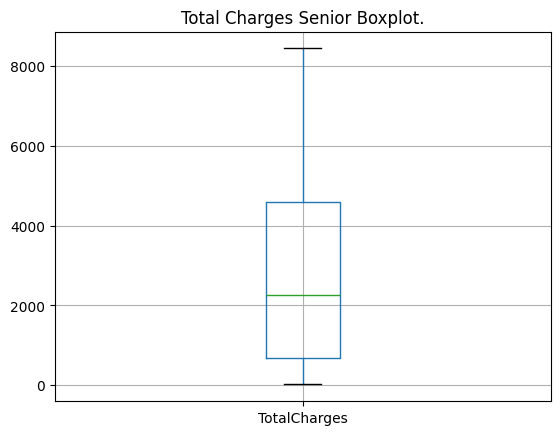

In [ ]:
df_all_together.query("SeniorCitizen == 1").boxplot(column='TotalCharges')
plt.title("Total Charges Senior Boxplot.")
plt.show()

No hay outliers en el conjunto senior.

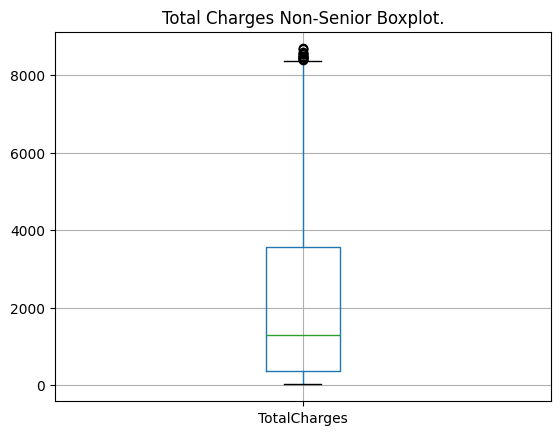

In [ ]:
df_all_together.query("SeniorCitizen == 0").boxplot(column='TotalCharges')
plt.title("Total Charges Non-Senior Boxplot.")
plt.show()

En la grafica de cliente que no son de la tercera edad se muestra outliers después de valor máximo.

#### Paso 3.2.1. Filtrado de outliers.

In [ ]:
#quitar outliers
q3 = df_all_together.query("SeniorCitizen == 0")['TotalCharges'].quantile(0.75)
q1 = df_all_together.query("SeniorCitizen == 0")['TotalCharges'].quantile(0.25)
iqr = q3 - q1 # rango intercuartílico
ls = q3 + 1.5*iqr # límite superior
li = q1 - 1.5*iqr # límite inferior

In [ ]:
print("Cantidad de registros antes con outliers.")
df_all_together.query("SeniorCitizen == 0")['TotalCharges'].count()

Cantidad de registros antes con outliers.


5864

In [ ]:
outliers = df_all_together.query("SeniorCitizen == 0 and TotalCharges > @ls")['TotalCharges']
print("Cantidad de registros con outliers.")
outliers.count()

Cantidad de registros con outliers.


19

In [ ]:
df_all_together = df_all_together.drop(index=outliers.index).reset_index(drop=True)

In [ ]:
df_all_together.shape

(6986, 21)

Conclusión:

- El 83% de los usuarios no son senior y en promedio pagan de cargos totales 2 180.
- Eliminamos 19 outliers identificados en el conjunto de no senior.

## Paso 4. Visualización de los datos.

Las vraibles nominales en el dataset son las siguientes:

In [ ]:
nominal = ['gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod']

Analizaremos cada una de la variables nominales para identificar la cantidad de usuarios que dejaron o no las compañía. Se creó una función llamada `pivot_table_per_features`

In [ ]:
def pivot_table_per_features(v_nom: list[str]):
    """
    Crea una tabla dinámica para cada característica en la lista `v_nom`, agrupada por la columna 'Churn',
    y muestra una matriz de gráficos de barras con el conteo de 'customerID' para cada combinación de características.

    Args:
    v_nom (list[str]): Lista de nombres de características (columnas) sobre las que se generarán las tablas dinámicas y los gráficos.

    Returns:
    None: La función muestra los gráficos de barras en una matriz de subgráficas pero no retorna nada.

    Example:
    >>> pivot_table_per_features(['Gender', 'Contract', 'PaymentMethod'])
    Muestra una matriz de gráficos de barras para cada una de las columnas 'Gender', 'Contract' y 'PaymentMethod'
    agrupados por 'Churn'.
    """

    # Número de subgráficas necesarias
    num_plots = len(v_nom)

    # Calcular el número de filas y columnas necesarias para la matriz de gráficos
    rows = math.ceil(num_plots / 3)  # Podemos poner hasta 3 columnas por fila
    cols = min(3, num_plots)         # Limitamos a 3 columnas por fila

    # Crear la figura y los subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))  # Ajusta el tamaño según las filas
    axes = axes.flatten()  # Aplanar para indexar de manera sencilla

    for idx, i in enumerate(v_nom):
        # Generar la tabla dinámica y el gráfico de barras
        ax = axes[idx]  # Obtener el subplot correspondiente
        df_all_together.pivot_table(index='Churn', columns=i, values='customerID', aggfunc='count').plot(kind='bar', ax=ax)
        ax.set_title(i)

    # Si hay subgráficas vacías, eliminarlas
    for idx in range(num_plots, len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()  # Ajustar para evitar que los títulos se solapen
    plt.show()


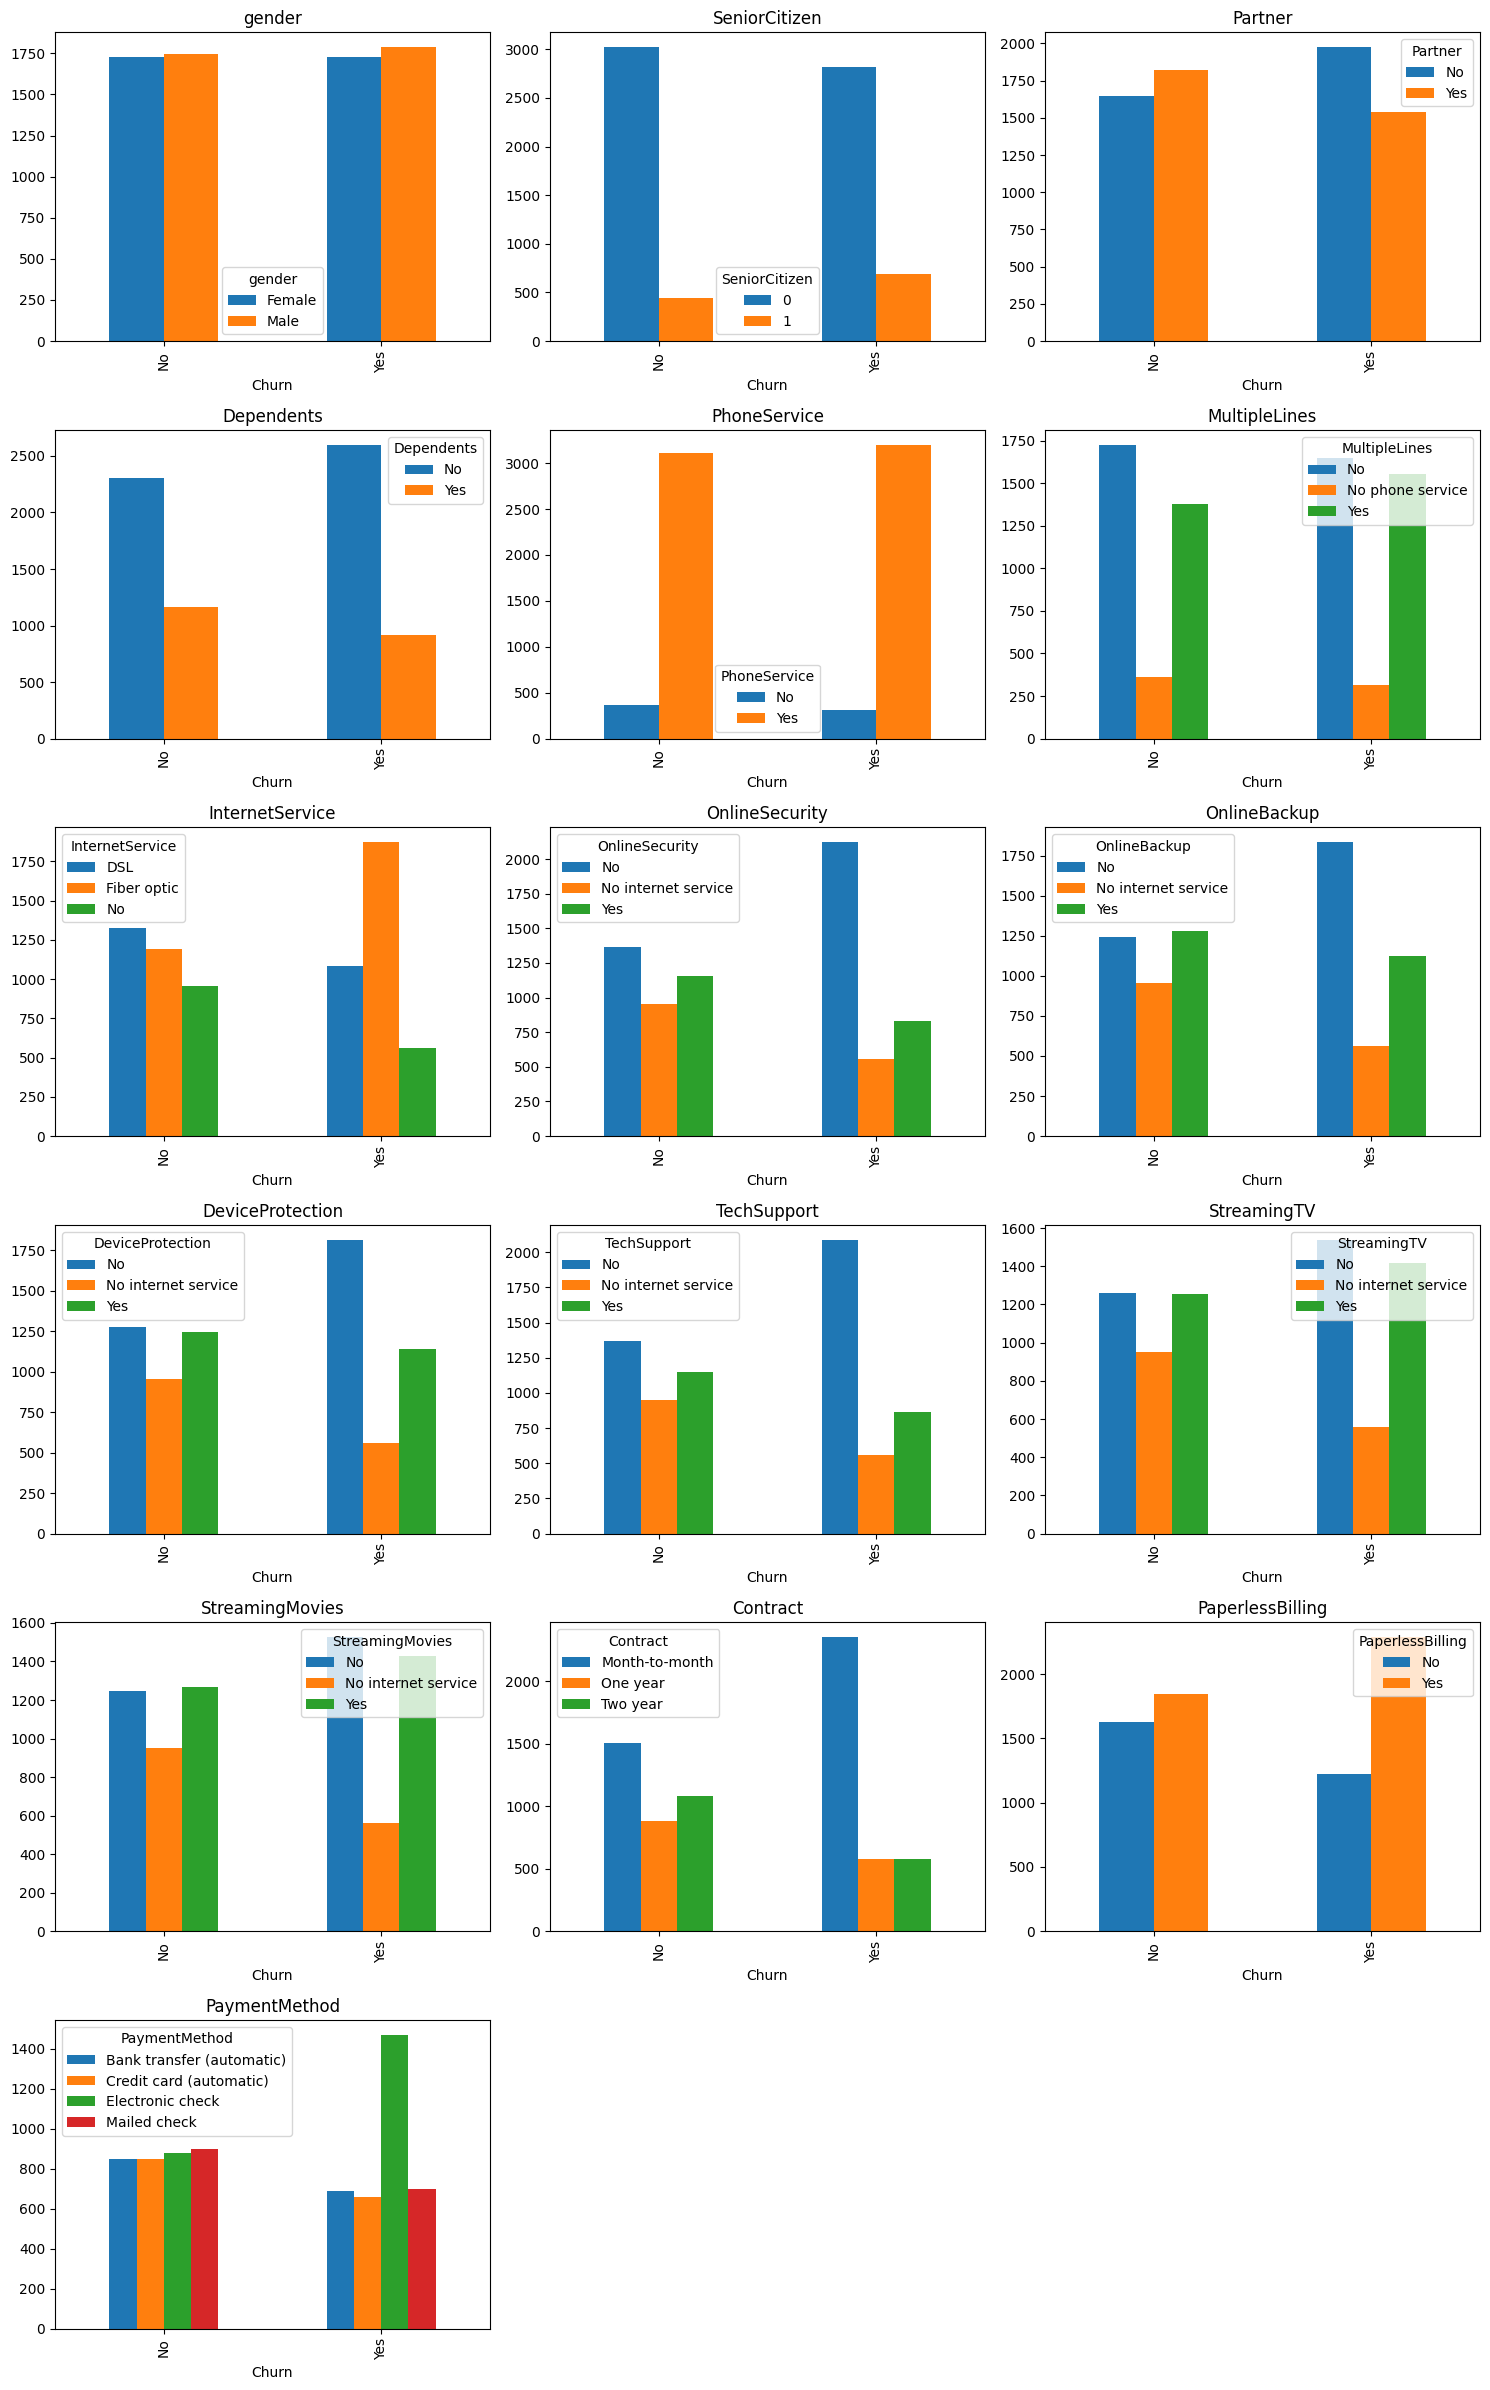

In [ ]:
pivot_table_per_features(nominal)

Las gráficas más notables son `InternetService`, `OnlineSecurity`, `OnlineBackup`,`DeviceProtection`, `TechSupport`, `StreamingTV` y `Contract`. Además podemos convertir los algunos servicios con varibales nominales a binarias (dummies). (MultipleLines, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies, Contract). En cuanto a la columna PaymentMethods, podemos aplicar OneHotEncoding. (No lo aplicamos)


## Paso 5. Correlación

Se aplicará correlación para conservar las columnas que tengan una alta correlación.


- Una variable nominal es una variable categórica que describe una etiqueta, un nombre o una categoría sin un orden natural.
- Una variable binaria es una variable que solo puede tener dos valores, que son mutuamente excluyentes y exhaustivos.
- Una variable numérica es una variable que se expresa con números y que representa una cantidad medible.

### Paso 5.1. Funciones convertir de variables de nominales a binarias.

In [ ]:
def change_to_binary_internet(df: pd.DataFrame) -> pd.DataFrame:
  """
  Convierte todo variable que no sea No a Yes.

  Args:
  df (pd.DataFrame): El DataFrame que contiene las columnas a convertir.

  Returns:
  pd.DataFrame: El DataFrame con las columnas convertidas.

  Example:
  >>> change_to_binary_internet(df)
  Devuelve un DataFrame con las columnas convertidas.

  """
  df['InternetService'] = df['InternetService'].where(~(df['InternetService'] != 'No'),'Yes')
  return df

In [ ]:
def change_to_binary(df: pd.DataFrame) -> pd.DataFrame:
  """
  Convierte todo variable que no sea No a Yes.

  Args:
  df (pd.DataFrame): El DataFrame que contiene las columnas a convertir.

  Returns:
  pd.DataFrame: El DataFrame con las columnas convertidas.

  Example:
  >>> change_to_binary(df)
  Devuelve un DataFrame con las columnas convertidas.
  """
  col = ['MultipleLines','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']
  for x in col:
    df[x] = df[x].where(~(df[x] != 'Yes'),'No')
  return df

### Paso 5.2. Aplicación de funciones change_to_binary_internet y change_to_binary.

In [ ]:
# Copia de seguridad.
df_corr_copy = df_all_together.copy()

In [ ]:
df_corr_copy = change_to_binary_internet(df_corr_copy)
df_corr_copy = change_to_binary(df_corr_copy)

In [ ]:
# Convertir las características a dummies y almacenarlas en una variable.
payment_dummies = df_corr_copy['PaymentMethod'].str.get_dummies()
contract = df_corr_copy['Contract'].str.get_dummies()
gender = df_corr_copy['gender'].str.get_dummies()

In [ ]:
# Descartamos las columnas ya que las convertirmos a dummy.
df_corr_copy = df_corr_copy.drop(['PaymentMethod','Contract','gender'],axis=1)

In [ ]:
# Unimos los dataframes que contienen los variables a dummies a df_corr_copy.
df_corr_copy = df_corr_copy.join([payment_dummies,contract,gender])

In [ ]:
#Columnas creadas.
df_corr_copy.columns

Index(['customerID', 'MonthlyCharges', 'TotalCharges', 'SeniorCitizen',
       'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'PaperlessBilling',
       'Churn', 'Bank transfer (automatic)', 'Credit card (automatic)',
       'Electronic check', 'Mailed check', 'Month-to-month', 'One year',
       'Two year', 'Female', 'Male'],
      dtype='object')

Por lo tanto, las siguiente caracetísticas son binarias:

In [ ]:
binary_variables = [
       'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'PaperlessBilling', 'Churn', 'Bank transfer (automatic)',
       'Credit card (automatic)', 'Electronic check', 'Mailed check',
       'Month-to-month', 'One year', 'Two year']

Codificaremos las varaibles binarios. (Yes: 1, No: 0)

In [ ]:
encoder = LabelEncoder()
df_binary = df_corr_copy[binary_variables].apply(encoder.fit_transform)

In [ ]:
df_binary

,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,...,StreamingMovies,PaperlessBilling,Churn,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check,Month-to-month,One year,Two year
0,0,1,0,0,0,1,0,1,0,0,...,0,1,1,0,0,1,0,1,0,0
1,0,0,0,1,0,1,1,0,1,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,0,1,0,1,1,1,0,0,...,0,1,1,0,0,0,1,1,0,0
3,0,0,0,0,0,1,1,0,1,1,...,0,0,1,1,0,0,0,0,1,0
4,0,0,0,1,0,1,0,0,0,0,...,0,1,1,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6981,0,0,0,1,1,1,1,1,1,0,...,0,1,1,0,1,0,0,1,0,0
6982,0,0,0,1,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
6983,0,0,0,0,0,1,0,1,1,1,...,1,0,0,0,0,1,0,0,1,0
6984,1,1,0,1,1,1,0,0,0,0,...,0,1,1,0,0,0,1,1,0,0


In [ ]:
#Las columnas mas correlacionadas.
bynary_corr_col = ['Dependents','Partner','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','Mailed check','Electronic check','Month-to-month','Bank transfer (automatic)','Credit card (automatic)','One year', 'Two year']

### Paso 5.3. Correlacción variables binarias.

In [ ]:
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    return np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

def cramers_v_matrix(df):
    cols = df.columns
    n_cols = len(cols)
    result = pd.DataFrame(np.zeros((n_cols, n_cols)), columns=cols, index=cols)

    for i in range(n_cols):
        for j in range(i, n_cols):
            if i == j:
                result.iloc[i, j] = 1.0
            else:
                result.iloc[i, j] = cramers_v(df.iloc[:, i], df.iloc[:, j])
                result.iloc[j, i] = result.iloc[i, j]

    return result

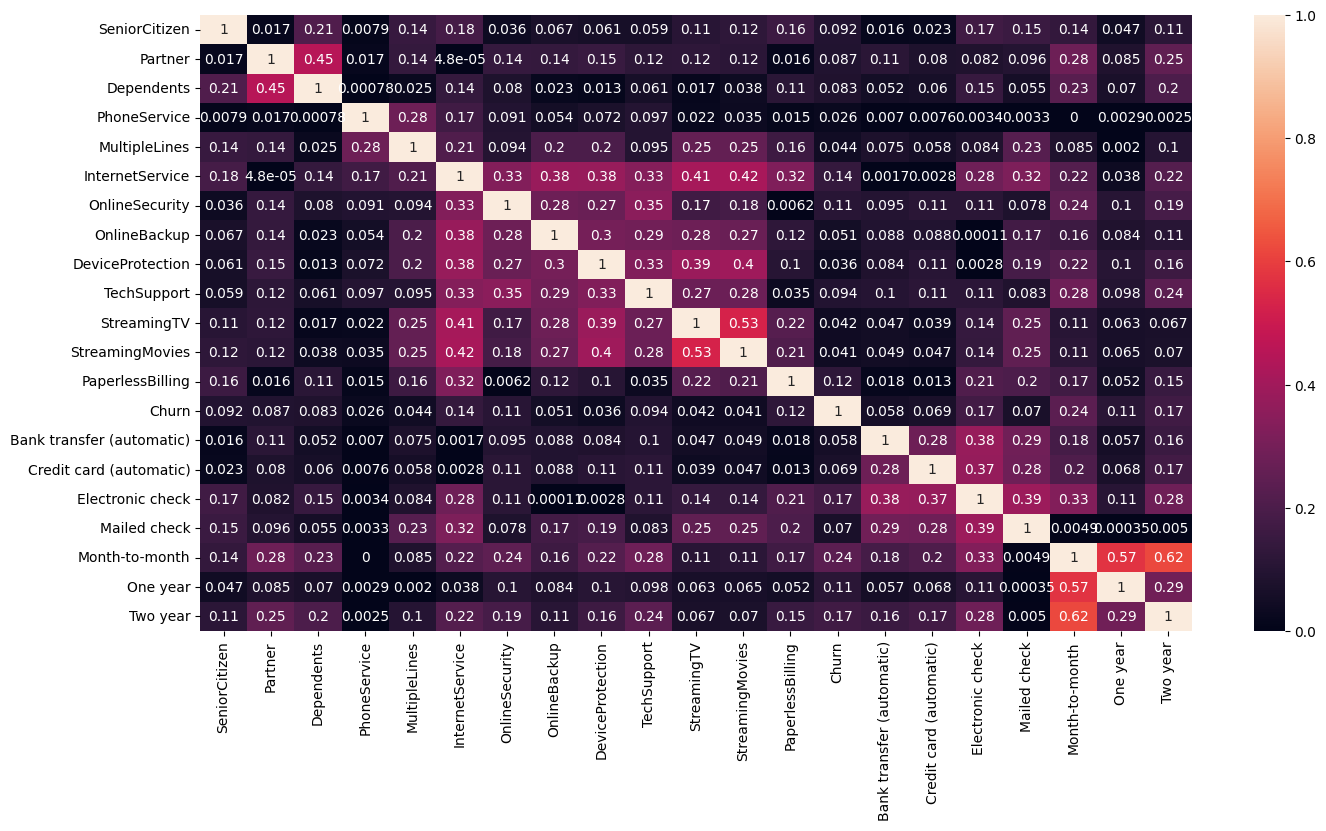

In [ ]:
plt.figure(figsize=(16,8))
sns.heatmap(cramers_v_matrix(df_binary),annot=True)
plt.show()

Consideraremos correlaciones mayores a 0.3 y menores a -0.3.

Columnas correlacinadas:
- Dependats y Partners (0.45)
- Con InternetService:
OnlineSecurity 0.33,
OnlineBackups 0.38,
DeviceProtection 0.38,
TechSupport 0.34,
StreamingTV 0.41,
StreamingMovies 0.42,
PaperlessBilling 0.32,
MailedCheck 0.32,
- TechSupport y OnlineSecurity (0.35)
Con DeviceProtection:
TechSupport 0.33,
StreamingTV (0.39),
StreamingMovies (0.4)
- StreamingTV y StreamingMovies (0.53)
- Electronic check y month-to-month 0.33
- Bank transfer y electronic check 0.38
- electronic check y credit card 0.37
- electronic check y mail check 0.39
- Con month-to-month
One year 0.57,
Two year 0.62

### Paso 5.4. Correlación variables numéricas.

In [ ]:
df_numeric = df_all_together[['MonthlyCharges','TotalCharges','tenure']]

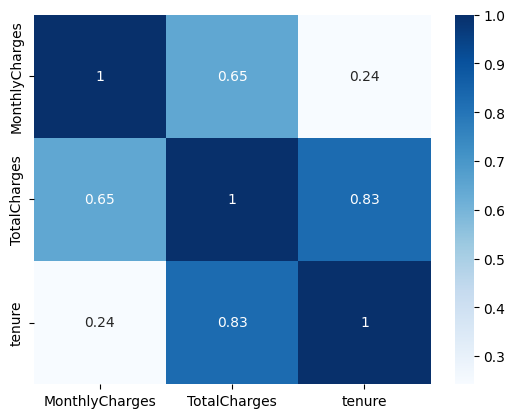

In [ ]:
sns.heatmap(df_numeric.corr(),annot=True,cmap='Blues')
plt.show()

In [ ]:
numeric_corr_col = ['TotalCharges','tenure']

La columnas más relaciandas entre sí son las siguientes:

- MonthlyCharges y TotalCharges (0.65)
- TotalCharges y tenure (0.83)

Conclusión.

- Las variables binarias con mayor correlación rondan entre entre 0.32 y 0.62.
- Las características mas correlacionadas son `StreeamingTV` y `StreamingMovies` (0.53),  `month-to-month` y `One year` (0.57) y `month.to.month` y `two year` (0.62).
- Las varibales numéricas con mayor correlación rondan entre 0.65 y 0.83.
- Las características mpas correlacionadas son  `MonthlyCharges` y `TotalCharges` (0.65) y `TotalCharges` y `tenure` (0.83).

# Parte II. Aplicación de Modelos.

Una vez realizado el análisis exploratorio de datos, donde cargamos los datasets, tratamos los datos eliminando duplicados y aplicamos técnicas de visualización, es el momento de predecir la variable Churn, que nos indica si el cliente se fue (No) o no se fue (Yes). La técnica de aprendizaje automático que utilizaremos es el aprendizaje supervisado, ya que nuestros datos están etiquetados. Los modelos que debemos utilizar para este tipo de datos son los de clasificación, ya que, dependiendo de las características con las que el modelo aprenderá, predecirá 1 (el cliente se fue) o 0 (el cliente no se fue).

In [ ]:
df = df_all_together.copy() # copia repalado de segruidad.
#Encoder sin dummies.
encoder = LabelEncoder()
df_binary_2 = df[nominal].apply(encoder.fit_transform)
#Guardar en un dataframe X las vriables ya codificadas.
X = df[numeric_corr_col].join(df_binary_2)

In [ ]:
X.head()

,TotalCharges,tenure,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,29.85,1,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2
1,1889.50,34,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3
2,108.15,2,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3
3,1840.75,45,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0
4,151.65,2,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2


In [ ]:
# Mapeo de las etiquetas.
y = df['Churn'].map({'Yes':1,'No':0})

In [ ]:
# Escalameinto Mínimo-Máximo.
min_max = MinMaxScaler()
X_scaled = X.copy()
#X_scaled[numeric_corr_col] = min_max.fit_transform(X_scaled[numeric_corr_col])
X_scaled = min_max.fit_transform(X_scaled)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [ ]:
# Validación de los características.
X_scaled

,TotalCharges,tenure,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
0,0.001312,0.000000,0.0,0.0,1.0,0.0,0.0,0.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.666667
1,0.222044,0.464789,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.5,0.0,1.000000
2,0.010605,0.014085,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000
3,0.216258,0.619718,1.0,0.0,0.0,0.0,0.0,0.5,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.5,0.0,0.000000
4,0.015769,0.014085,0.0,0.0,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6981,0.815137,0.929577,0.0,0.0,0.0,0.0,1.0,1.0,0.5,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.333333
6982,0.175231,0.253521,1.0,0.0,0.0,0.0,1.0,0.0,0.5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000
6983,0.085995,0.154930,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.5,0.0,0.666667
6984,0.034161,0.042254,1.0,1.0,1.0,0.0,1.0,1.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000


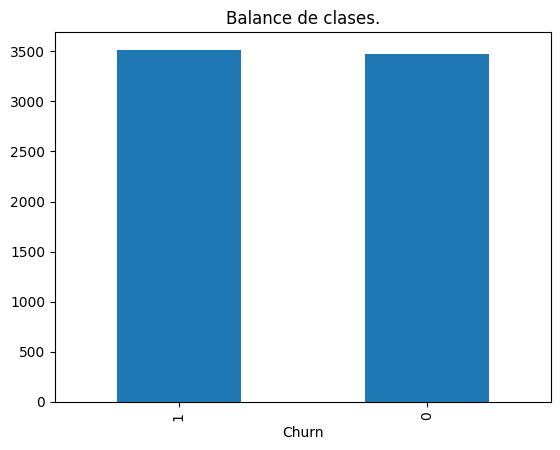

In [ ]:
y.value_counts().plot(kind='bar')
plt.title("Balance de clases.")
plt.show()

## Paso 6. Seleccion de caracteristicas por otros métodos.

### SelectKBest

In [ ]:
selector = SelectKBest(score_func=f_classif, k=10)
X_selected = selector.fit_transform(X_scaled, y)

selected_features = X_scaled.columns[selector.get_support(indices=True)]
print(f"Características más importantes:\n {selected_features}")

Características más importantes:
 Index(['TotalCharges', 'tenure', 'SeniorCitizen', 'Partner', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling'],
      dtype='object')


### RandomForest

In [ ]:
model = RandomForestClassifier(random_state=0)
model.fit(X_scaled, y)

importances = model.feature_importances_
important_features = X_scaled.columns[importances > 0.05]

print(f"Características más importantes:\n {important_features}")

Características más importantes:
 Index(['TotalCharges', 'tenure', 'PaymentMethod'], dtype='object')


### Lasso

In [ ]:
lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, y)

important_features = X_scaled.columns[lasso.coef_ != 0]
print(f"Características más importantes:\n {important_features}")

Características más importantes:
 Index(['tenure', 'SeniorCitizen', 'MultipleLines', 'OnlineSecurity',
       'OnlineBackup', 'TechSupport', 'Contract', 'PaperlessBilling'],
      dtype='object')


In [ ]:
most_important_features = list(set(['TotalCharges', 'tenure', 'SeniorCitizen', 'Partner', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling','TotalCharges', 'tenure', 'PaymentMethod','tenure', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingMovies', 'Contract',
       'PaperlessBilling']))

In [ ]:
most_important_features

['OnlineSecurity',
 'Contract',
 'tenure',
 'TotalCharges',
 'SeniorCitizen',
 'TechSupport',
 'PaperlessBilling',
 'MultipleLines',
 'StreamingMovies',
 'OnlineBackup',
 'PaymentMethod',
 'Partner',
 'DeviceProtection']

In [ ]:
X_scaled.describe()

,TotalCharges,tenure,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
count,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000,6986.000000
mean,0.266682,0.440668,0.505583,0.163327,0.481105,0.298025,0.903092,0.468151,0.435872,0.392786,0.451761,0.449757,0.396650,0.490839,0.494561,0.342256,0.591612,0.524716
std,0.266616,0.344824,0.500005,0.369690,0.499679,0.457423,0.295854,0.474121,0.369036,0.429445,0.439991,0.439767,0.430392,0.442533,0.442595,0.415547,0.491571,0.355929
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.045075,0.112676,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333
50%,0.162842,0.394366,1.000000,0.000000,0.000000,0.000000,1.000000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.000000,1.000000,0.666667
75%,0.445243,0.760563,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,1.000000,0.666667
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Paso 8. Dividir conjunto de datos.
 los datos se dividieron en tres:
 - Entrenameinto (80%).
 - Dev(10%).
 - Test(10%)

In [ ]:
# ['TotalCharges', 'tenure', 'SeniorCitizen', 'Partner', 'OnlineSecurity',
# 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling',
# 'PaymentMethod', 'MultipleLines', 'OnlineBackup', 'StreamingMovies']

In [ ]:
#X_scaled = X_scaled[['TotalCharges', 'tenure', 'PaymentMethod']].copy()
X_scaled = X_scaled[["TotalCharges","tenure","OnlineSecurity","DeviceProtection","TechSupport"]]#Datos escalados con las características más importantes.
X_train, X_dev, y_train, y_dev = train_test_split(X_scaled, y, train_size=0.9, random_state=42)
X_dev, X_test, y_dev, y_test = train_test_split(X_dev, y_dev, test_size=0.5, random_state=42)

In [ ]:
X_scaled.head()

,TotalCharges,tenure,OnlineSecurity,DeviceProtection,TechSupport
0,0.001312,0.000000,0.0,0.0,0.0
1,0.222044,0.464789,1.0,1.0,0.0
2,0.010605,0.014085,1.0,0.0,0.0
3,0.216258,0.619718,1.0,1.0,1.0
4,0.015769,0.014085,0.0,0.0,0.0


In [ ]:
print("Dimensión del conjunto de entrenamiento:")
print(X_train.shape)
print(y_train.shape)
print("\nDimensión del conjunto de validación:")
print(X_dev.shape)
print(y_dev.shape)
print("\nDimensión del conjunto de prueba:")
print(X_test.shape)
print(y_test.shape)

Dimensión del conjunto de entrenamiento:
(6287, 5)
(6287,)

Dimensión del conjunto de validación:
(349, 5)
(349,)

Dimensión del conjunto de prueba:
(350, 5)
(350,)


## Paso 7. Regresion Logística.

In [ ]:
r_logistic_model = LogisticRegression()
r_logistic_model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_train_pred = r_logistic_model.predict(X_train)
y_dev_pred = r_logistic_model.predict(X_dev)
y_test_pred = r_logistic_model.predict(X_test)

In [ ]:
print(f"Accuracy Entrenamiento: {accuracy_score(y_train,y_train_pred)}")
print(f"Accuracy Dev: {accuracy_score(y_dev,y_dev_pred)}")
print(f"Accuracy Prueba: {accuracy_score(y_test, y_test_pred)}\n")

print(f"ROC AUC score Entrenamiento: {roc_auc_score(y_train,y_train_pred)}")
print(f"ROC AUC score Dev: {roc_auc_score(y_dev,y_dev_pred)}")
print(f"ROC AUC score Prueba: {roc_auc_score(y_test, y_test_pred)}")

Accuracy Entrenamiento: 0.6144425003976459
Accuracy Dev: 0.5730659025787965
Accuracy Prueba: 0.6257142857142857

ROC AUC score Entrenamiento: 0.6142307753028129
ROC AUC score Dev: 0.5734549638395792
ROC AUC score Prueba: 0.6251632706374086


Porbando la calidad del primero modelo, regresión logística, tanto en accuracy como en ROC AUC obtuvimos los resultados muy parecidos. Aunque El model no generó ningún overfitting, la métricas no fueron buenas.

In [ ]:
def confussion_matrix_multiplot():

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()

    sns.heatmap(confusion_matrix(y_train, y_train_pred), annot=True, cmap='Blues', fmt='g', ax=axes[0])
    axes[0].set_title("Matriz de confusión - Entrenamiento")
    axes[0].set_xlabel("Predicción")
    axes[0].set_ylabel("Valor real")

    sns.heatmap(confusion_matrix(y_dev, y_dev_pred), annot=True, cmap='Blues', fmt='g', ax=axes[1])
    axes[1].set_title("Matriz de confusión - Prueba")
    axes[1].set_xlabel("Predicción")
    axes[1].set_ylabel("Valor real")

    sns.heatmap(confusion_matrix(y_test, y_test_pred), annot=True, cmap='Blues', fmt='g', ax=axes[2])
    axes[2].set_title("Matriz de confusión - Validación")
    axes[2].set_xlabel("Predicción")
    axes[2].set_ylabel("Valor real")

    plt.show()

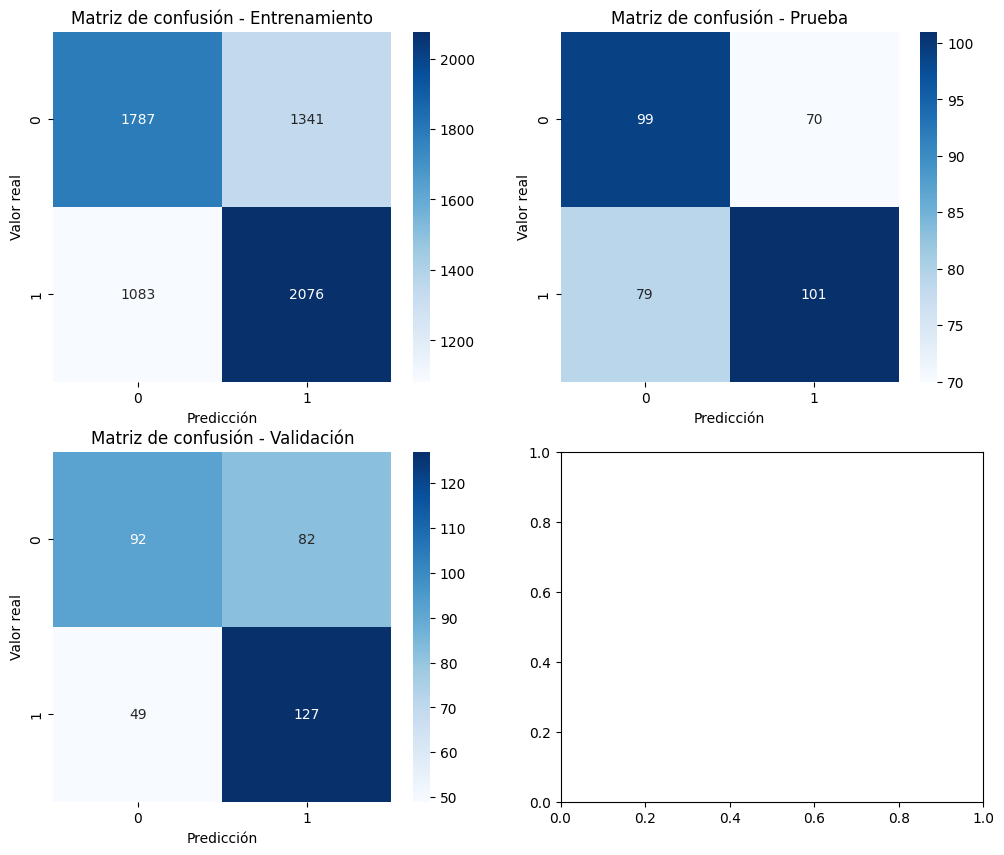

In [ ]:
confussion_matrix_multiplot()

### Regresión Lineal con validación cruzada.

In [ ]:
r_logistic_model_cv = LogisticRegression()
accuracy = cross_val_score(r_logistic_model_cv, X_scaled, y, cv=10).mean()
print(f"Accuracy: {accuracy}")

Accuracy: 0.6125582596505035


### Learning Curve

In [ ]:
from sklearn.model_selection import learning_curve

In [ ]:
y.value_counts()

,count
Churn,
1,3515
0,3471


In [ ]:
from sklearn.model_selection import learning_curve, StratifiedKFold

## Paso 8. Arboles de Decisiones.

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
def model_performance(model, X_train, y_train, X_dev, y_dev, X_test, y_test):
  model.fit(X_train, y_train)
  y_train_pred = model.predict(X_train)
  y_dev_pred = model.predict(X_dev)
  y_test_pred = model.predict(X_test)

  acc_train = accuracy_score(y_train, y_train_pred)
  acc_dev = accuracy_score(y_dev, y_dev_pred)
  acc_test = accuracy_score(y_test, y_test_pred)

  roc_auc_train = roc_auc_score(y_train, y_train_pred)
  roc_auc_dev = roc_auc_score(y_dev, y_dev_pred)
  roc_auc_test = roc_auc_score(y_test, y_test_pred)

  print(f"Accuracy Entrenamiento: {acc_train}")
  print(f"Accuracy Dev: {acc_dev}")
  print(f"Accuracy Prueba: {acc_test}\n")

  print(f"ROC AUC score Entrenamiento: {roc_auc_train}")
  print(f"ROC AUC score Dev: {roc_auc_dev}")
  print(f"ROC AUC score Prueba: {roc_auc_test}")

  return acc_train, acc_dev, acc_test, roc_auc_train, roc_auc_dev, roc_auc_test

In [ ]:
model_performance(dt_model, X_train, y_train, X_dev, y_dev, X_test, y_test)

Accuracy Entrenamiento: 0.9895021472880547
Accuracy Dev: 0.5415472779369628
Accuracy Prueba: 0.5828571428571429

ROC AUC score Entrenamiento: 0.9895269898289222
ROC AUC score Dev: 0.5405489809335963
ROC AUC score Prueba: 0.5827129049111808


(0.9895021472880547,
 0.5415472779369628,
 0.5828571428571429,
 0.9895269898289222,
 0.5405489809335963,
 0.5827129049111808)

El modelo tuvo altas métricas en el conjunto entranmeinto; no obstante los resultados en el resto de los conjuntos no fue destacable.  El árboles de decición presentó overfitting.

### 8.1 Cambiando hiperparamaetro max_depth

In [ ]:
# 9.1.1 Listas donde se irán almecando las métricas de accuracy y roc auc obtenidas por modelos con distintos hiperparametros en los 3 conjuntos de datos.
acc_list_train = []
acc_list_dev = []
acc_list_test = []
roc_auc_list_train = []
roc_auc_list_dev = []
roc_auc_list_test = []

# 9.1.2 Ciclo for en el que se van a entrenar y evaluar 24 modelos diferentes cambiando el hiperparametro max_depth y guardar el score de accuracy y auc roc en sus respectivas listas.
for x in range(1,25):
  dt_model = DecisionTreeClassifier(max_depth=x)
  print(f"\nMax depth {x}:")
  acc_train, acc_dev, acc_test, roc_auc_train, roc_auc_dev, roc_auc_test = model_performance(dt_model, X_train, y_train, X_dev, y_dev, X_test, y_test)

  acc_list_train.append(acc_train)
  acc_list_dev.append(acc_dev)
  acc_list_test.append(acc_test)

  roc_auc_list_train.append(roc_auc_train)
  roc_auc_list_dev.append(roc_auc_dev)
  roc_auc_list_test.append(roc_auc_test)


Max depth 1:
Accuracy Entrenamiento: 0.6056942898043582
Accuracy Dev: 0.5816618911174785
Accuracy Prueba: 0.6285714285714286

ROC AUC score Entrenamiento: 0.6057090163370357
ROC AUC score Dev: 0.5814266929651546
ROC AUC score Prueba: 0.6284939916405434

Max depth 2:
Accuracy Entrenamiento: 0.6111022745347543
Accuracy Dev: 0.5787965616045845
Accuracy Prueba: 0.6314285714285715

ROC AUC score Entrenamiento: 0.6108834094767599
ROC AUC score Dev: 0.5768408941485864
ROC AUC score Prueba: 0.6310410135841169

Max depth 3:
Accuracy Entrenamiento: 0.625258469858438
Accuracy Dev: 0.5702005730659025
Accuracy Prueba: 0.6314285714285715

ROC AUC score Entrenamiento: 0.6255364144501683
ROC AUC score Dev: 0.5728468113083498
ROC AUC score Prueba: 0.6313675548589343

Max depth 4:
Accuracy Entrenamiento: 0.6301892794655639
Accuracy Dev: 0.5787965616045845
Accuracy Prueba: 0.64

ROC AUC score Entrenamiento: 0.6305606763123103
ROC AUC score Dev: 0.5819033530571992
ROC AUC score Prueba: 0.6400862068965517

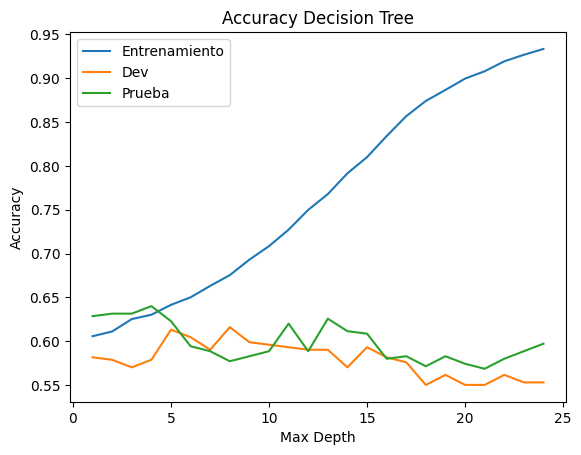

In [ ]:
# 9.1.3
plt.plot(range(1,25),acc_list_train,label="Entrenamiento")
plt.plot(range(1,25),acc_list_dev,label="Dev")
plt.plot(range(1,25),acc_list_test,label="Prueba")
plt.title("Accuracy Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

A pesar de que hemos intereactuado con diferentes modelos aplicando ajuste de parámetros, sigue apareciendo overfitting, además de que cuanto mayor sea las profunidad de los modelos menor es la precisión.

In [ ]:
dt_model = DecisionTreeClassifier(max_depth=5)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Asegura proporción de clases
train_sizes = np.linspace(0.1, 1.0, 5)  # Evita tamaños demasiado pequeños

train_sizes, train_scores, test_scores = learning_curve(
    dt_model, X_scaled, y, cv=cv, train_sizes=train_sizes, error_score='raise'
)

In [ ]:
train_scores.mean(axis=1)

array([1.        , 0.99614537, 0.70257078, 0.63103926, 0.64040802])

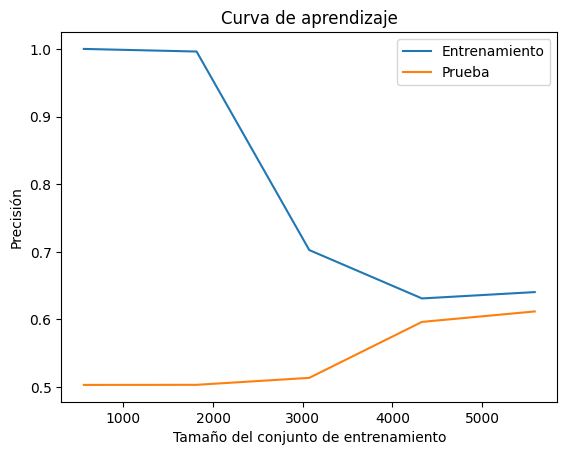

In [ ]:
plt.plot(train_sizes, train_scores.mean(axis=1), label='Entrenamiento')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Prueba')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de aprendizaje')
plt.legend()
plt.show()

### 8.2 validación cruzada.

In [ ]:
val_mean_list = []
for x in range(1,25):
  print(f"\nMax depth {x}:")
  model = DecisionTreeClassifier(max_depth=x)
  val_mean = cross_val_score(model, X_scaled, y, cv=10).mean()
  print(val_mean)
  val_mean_list.append(val_mean)


Max depth 1:
0.6056779845132835

Max depth 2:
0.608254526523769

Max depth 3:
0.6164221503498654

Max depth 4:
0.616567056499051

Max depth 5:
0.615709507237109

Max depth 6:
0.6194245975626254

Max depth 7:
0.6149911252669593

Max depth 8:
0.6108329131669885

Max depth 9:
0.6062533049669812

Max depth 10:
0.6018149136506923

Max depth 11:
0.5988069325397313

Max depth 12:
0.5947989555279545

Max depth 13:
0.5837733807198987

Max depth 14:
0.5832027743276313

Max depth 15:
0.5766116966112047

Max depth 16:
0.5727514951773103

Max depth 17:
0.5747488225094384

Max depth 18:
0.5734633184532959

Max depth 19:
0.5684504265200798

Max depth 20:
0.5630085549967003

Max depth 21:
0.5654442900418527

Max depth 22:
0.5591419998278343

Max depth 23:
0.5588573115092785

Max depth 24:
0.5561358633496071


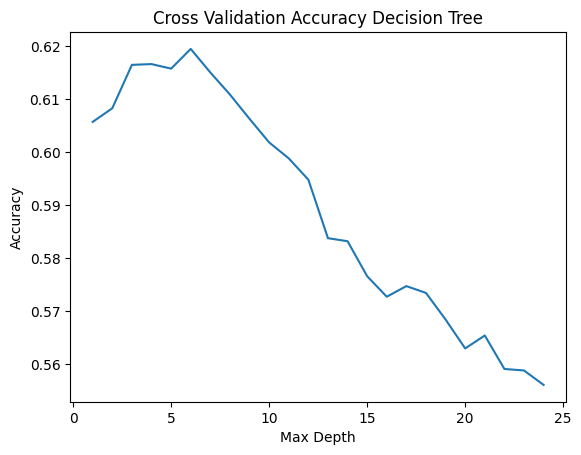

In [ ]:
plt.plot(range(1,25),val_mean_list)
plt.title("Cross Validation Accuracy Decision Tree")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.show()

Mismo caso qué en la gráfica anterior.

## Paso 9. Bosques Aleatorios.

In [ ]:
acc_list_train = []
acc_list_dev = []
acc_list_test = []
roc_auc_list_train = []
roc_auc_list_dev = []
roc_auc_list_test = []
for x in range(1,25):
  dt_model = RandomForestClassifier(max_depth=x)
  print(f"\nMax depth {x}:")
  acc_train, acc_dev, acc_test, roc_auc_train, roc_auc_dev, roc_auc_test = model_performance(dt_model, X_train, y_train, X_dev, y_dev, X_test, y_test)

  acc_list_train.append(acc_train)
  acc_list_dev.append(acc_dev)
  acc_list_test.append(acc_test)

  roc_auc_list_train.append(roc_auc_train)
  roc_auc_list_dev.append(roc_auc_dev)
  roc_auc_list_test.append(roc_auc_test)


Max depth 1:
Accuracy Entrenamiento: 0.6241450612374742
Accuracy Dev: 0.5644699140401146
Accuracy Prueba: 0.62

ROC AUC score Entrenamiento: 0.6244629783454734
ROC AUC score Dev: 0.5678336620644313
ROC AUC score Prueba: 0.620101880877743

Max depth 2:
Accuracy Entrenamiento: 0.6243041196118976
Accuracy Dev: 0.5702005730659025
Accuracy Prueba: 0.6228571428571429

ROC AUC score Entrenamiento: 0.6246526285067063
ROC AUC score Dev: 0.5737508218277448
ROC AUC score Prueba: 0.6229754440961337

Max depth 3:
Accuracy Entrenamiento: 0.6284396373469063
Accuracy Dev: 0.5759312320916905
Accuracy Prueba: 0.6171428571428571

ROC AUC score Entrenamiento: 0.6287192278951301
ROC AUC score Dev: 0.5789447731755424
ROC AUC score Prueba: 0.617130355276907

Max depth 4:
Accuracy Entrenamiento: 0.6346429139494194
Accuracy Dev: 0.5787965616045845
Accuracy Prueba: 0.6314285714285715

ROC AUC score Entrenamiento: 0.6348936360125619
ROC AUC score Dev: 0.5815417488494411
ROC AUC score Prueba: 0.6314328631138977


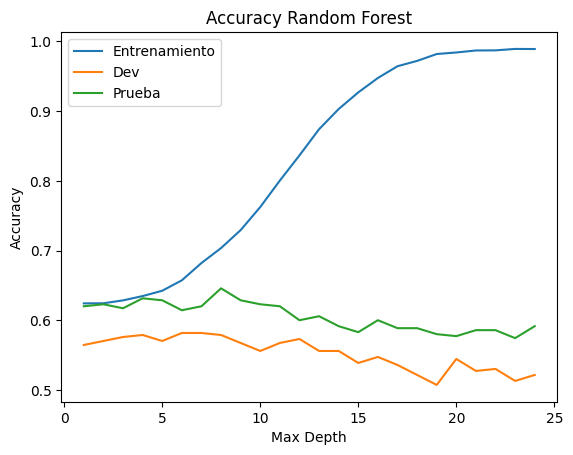

In [ ]:
plt.plot(range(1,25),acc_list_train,label="Entrenamiento")
plt.plot(range(1,25),acc_list_dev,label="Dev")
plt.plot(range(1,25),acc_list_test,label="Prueba")
plt.title("Accuracy Random Forest")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Los resulltado de esta gráfica fueron muy similares a los modelos de Árboles de Decisión.  

In [ ]:
rd_model = RandomForestClassifier(max_depth=10)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Asegura proporción de clases
train_sizes = np.linspace(0.1, 1.0, 5)  # Evita tamaños demasiado pequeños

train_sizes, train_scores, test_scores = learning_curve(
    rd_model, X_scaled, y, cv=cv, train_sizes=train_sizes
)

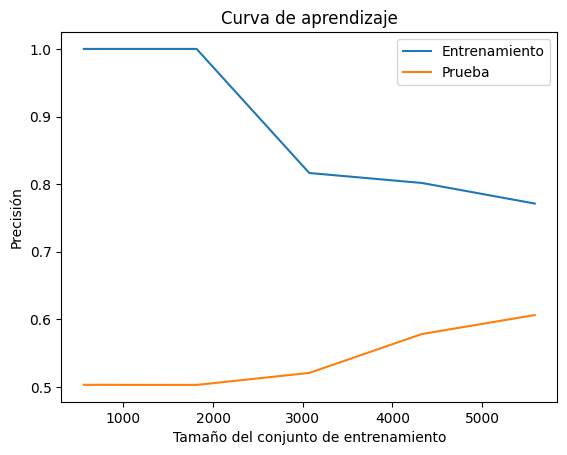

In [ ]:
plt.plot(train_sizes, train_scores.mean(axis=1), label='Entrenamiento')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Prueba')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de aprendizaje')
plt.legend()
plt.show()

### 9.1 Cruva de aprendizaje y Validación cruzada.

In [ ]:
val_mean_list = []
for x in range(1,5):
  print(f"\nMax depth {x}:")
  model = RandomForestClassifier(max_depth=x)
  val_mean = cross_val_score(model, X_scaled, y, cv=10).mean()
  print(val_mean)
  val_mean_list.append(val_mean)


Max depth 1:
0.6161372570721169

Max depth 2:
0.6201452340838939

Max depth 3:
0.6224374976942091

Max depth 4:
0.6212948501953262


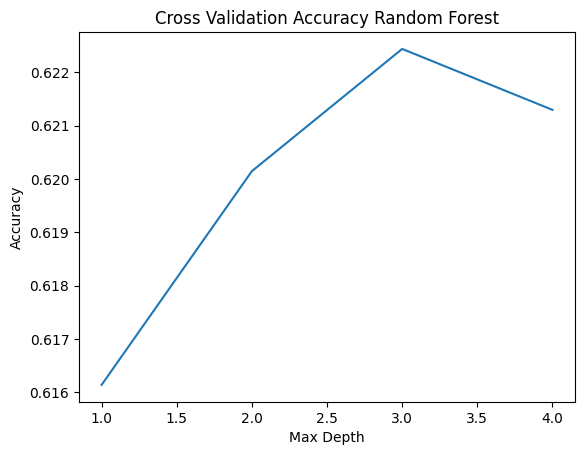

In [ ]:
plt.plot(range(1,5),val_mean_list)
plt.title("Cross Validation Accuracy Random Forest")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.show()

El modelo con la el mejor resultado fue el modelo que tuve una profundiad de 5. Conforme se va a avaznado va disminuyendo la precisión.

## Paso 9. Catboost

In [ ]:
catboost = CatBoostClassifier(logging_level='Silent')
catboost.fit(X_train,y_train)

In [ ]:
print(f"Accuracy Entrenamiento: {accuracy_score(y_train,y_train_pred)}")
print(f"Accuracy Dev: {accuracy_score(y_dev,y_dev_pred)}")
print(f"Accuracy Prueba: {accuracy_score(y_test, y_test_pred)}\n")

Accuracy Entrenamiento: 0.6144425003976459
Accuracy Dev: 0.5730659025787965
Accuracy Prueba: 0.6257142857142857



El modelo sigue presentando overfitting.

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

# Definir el undersampler con una estrategia personalizada
undersampler = RandomUnderSampler(sampling_strategy={0: 2000, 1: 2000}, random_state=42)

# Aplicar el undersampling
X_balanced, y_balanced = undersampler.fit_resample(X_scaled, y)

In [ ]:
catboost = CatBoostClassifier(logging_level='Silent')

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)  # Asegura proporción de clases
train_sizes = np.linspace(0.1, 1.0, 5)  # Evita tamaños demasiado pequeños

train_sizes, train_scores, test_scores = learning_curve(
    catboost, X_balanced, y_balanced, cv=cv, train_sizes=train_sizes
)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 5245, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, graph, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/usr/local/lib/python3.11/dist-packages/catboost/core.py", line 2410, in _fi

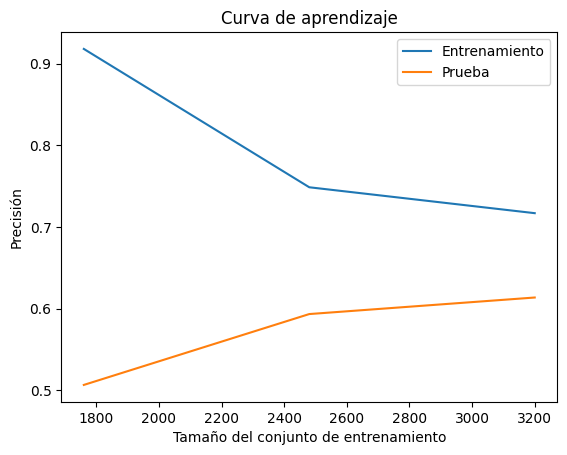

In [ ]:
plt.plot(train_sizes, train_scores.mean(axis=1), label='Entrenamiento')
plt.plot(train_sizes, test_scores.mean(axis=1), label='Prueba')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de aprendizaje')
plt.legend()
plt.show()

A pesar de que no he se hizo ninguna modificación en el modelo, con la función model_performance mejoró la exactitus en el conjunto de validación y prueba.

### Validación cruzada.

In [ ]:
catboost = CatBoostClassifier()
val_mean = cross_val_score(catboost, X_scaled, y, cv=10).mean()
print(val_mean)

Se truncaron las últimas líneas 5000 del resultado de transmisión.
5:	learn: 0.6819266	total: 13.3ms	remaining: 2.2s
6:	learn: 0.6804240	total: 15.6ms	remaining: 2.21s
7:	learn: 0.6787808	total: 17.9ms	remaining: 2.22s
8:	learn: 0.6771523	total: 20.2ms	remaining: 2.23s
9:	learn: 0.6756878	total: 23ms	remaining: 2.28s
10:	learn: 0.6743797	total: 25.3ms	remaining: 2.27s
11:	learn: 0.6732549	total: 27.1ms	remaining: 2.23s
12:	learn: 0.6720096	total: 29.3ms	remaining: 2.22s
13:	learn: 0.6709110	total: 31.4ms	remaining: 2.21s
14:	learn: 0.6698324	total: 33.6ms	remaining: 2.21s
15:	learn: 0.6685810	total: 35.8ms	remaining: 2.2s
16:	learn: 0.6676725	total: 37.7ms	remaining: 2.18s
17:	learn: 0.6665429	total: 40ms	remaining: 2.18s
18:	learn: 0.6655199	total: 42ms	remaining: 2.17s
19:	learn: 0.6649086	total: 43.6ms	remaining: 2.14s
20:	learn: 0.6640851	total: 46.1ms	remaining: 2.15s
21:	learn: 0.6632241	total: 51.9ms	remaining: 2.31s
22:	learn: 0.6623220	total: 59.6ms	remaining: 2.53s
23:	learn:

In [ ]:
print(f"Validation Score Accuracy: {val_mean}")

Validation Score Accuracy: 0.6205721640821313


## XGBoost

In [ ]:
X_train

,TotalCharges,tenure,OnlineSecurity,DeviceProtection,TechSupport
5850,0.210192,0.985915,0.5,0.5,0.5
4168,0.117829,0.281690,1.0,0.0,1.0
6367,0.117283,0.549296,0.5,0.5,0.5
4602,0.402474,0.450704,0.0,1.0,0.0
6477,0.108203,0.126761,0.0,0.0,0.0
...,...,...,...,...,...
3772,0.176507,0.239437,0.0,0.0,1.0
5191,0.090879,0.112676,1.0,0.0,0.0
5226,0.251683,0.549296,1.0,0.0,0.0
5390,0.500635,0.633803,0.0,1.0,1.0


In [ ]:
X_dev

,TotalCharges,tenure,OnlineSecurity,DeviceProtection,TechSupport
4318,0.037033,0.197183,0.5,0.5,0.5
5839,0.061686,0.309859,0.5,0.5,0.5
5152,0.631171,1.000000,1.0,1.0,1.0
5689,0.108856,0.661972,0.5,0.5,0.5
2131,0.056891,0.323944,0.5,0.5,0.5
...,...,...,...,...,...
6554,0.935281,1.000000,0.0,1.0,1.0
3206,0.051484,0.323944,0.5,0.5,0.5
1046,0.057817,0.352113,0.5,0.5,0.5
3529,0.302597,0.380282,0.0,0.0,0.0


In [ ]:
model = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

model_performance(model, X_train, y_train, X_dev, y_dev, X_test, y_test)

Accuracy Entrenamiento: 0.7838396691585812
Accuracy Dev: 0.5157593123209169
Accuracy Prueba: 0.6

ROC AUC score Entrenamiento: 0.7838995109171296
ROC AUC score Dev: 0.5164529914529915
ROC AUC score Prueba: 0.6000522466039708


(0.7838396691585812,
 0.5157593123209169,
 0.6,
 0.7838995109171296,
 0.5164529914529915,
 0.6000522466039708)

In [ ]:
model = XGBClassifier()
#model.fit(X_train, y_train)

model_performance(model, X_train, y_train, X_dev, y_dev, X_test, y_test)

Accuracy Entrenamiento: 0.7665023063464291
Accuracy Dev: 0.5472779369627507
Accuracy Prueba: 0.6028571428571429

ROC AUC score Entrenamiento: 0.7665907458817377
ROC AUC score Dev: 0.547370151216305
ROC AUC score Prueba: 0.6027951933124347


(0.7665023063464291,
 0.5472779369627507,
 0.6028571428571429,
 0.7665907458817377,
 0.547370151216305,
 0.6027951933124347)

In [ ]:
xgboost = XGBClassifier()
val_mean = cross_val_score(xgboost, X_scaled, y, cv=10).mean()
print(val_mean)

0.5916485277781194


In [ ]:
model = XGBClassifier(learning_rate=0.1, max_depth=100)
#model.fit(X_train, y_train)

model_performance(model, X_train, y_train, X_dev, y_dev, X_test, y_test)

Accuracy Entrenamiento: 0.8891363130268809
Accuracy Dev: 0.5186246418338109
Accuracy Prueba: 0.6085714285714285

ROC AUC score Entrenamiento: 0.8890904807358346
ROC AUC score Dev: 0.5186883629191321
ROC AUC score Prueba: 0.6082157784743991


(0.8891363130268809,
 0.5186246418338109,
 0.6085714285714285,
 0.8890904807358346,
 0.5186883629191321,
 0.6082157784743991)

### Cmabiando hiperparametros max_depth

In [ ]:
acc_list_train = []
acc_list_dev = []
acc_list_test = []
roc_auc_list_train = []
roc_auc_list_dev = []
roc_auc_list_test = []
for x in range(1,40):
  model = XGBClassifier(max_depth=x,learning_rate=0.2)
  print(f"\nMax depth {x}:")
  acc_train, acc_dev, acc_test, roc_auc_train, roc_auc_dev, roc_auc_test = model_performance(model, X_train, y_train, X_dev, y_dev, X_test, y_test)

  acc_list_train.append(acc_train)
  acc_list_dev.append(acc_dev)
  acc_list_test.append(acc_test)

  roc_auc_list_train.append(roc_auc_train)
  roc_auc_list_dev.append(roc_auc_dev)
  roc_auc_list_test.append(roc_auc_test)


Max depth 1:
Accuracy Entrenamiento: 0.6285986957213298
Accuracy Dev: 0.5616045845272206
Accuracy Prueba: 0.6371428571428571

ROC AUC score Entrenamiento: 0.6286751549787923
ROC AUC score Dev: 0.5634286653517423
ROC AUC score Prueba: 0.636984064785789

Max depth 2:
Accuracy Entrenamiento: 0.651025926515031
Accuracy Dev: 0.6045845272206304
Accuracy Prueba: 0.64

ROC AUC score Entrenamiento: 0.6513029289919031
ROC AUC score Dev: 0.6076265614727153
ROC AUC score Prueba: 0.6401188610240335

Max depth 3:
Accuracy Entrenamiento: 0.6659774137108319
Accuracy Dev: 0.5931232091690545
Accuracy Prueba: 0.6371428571428571

ROC AUC score Entrenamiento: 0.6662688972116365
ROC AUC score Dev: 0.595792241946088
ROC AUC score Prueba: 0.6373432601880877

Max depth 4:
Accuracy Entrenamiento: 0.6876093526324161
Accuracy Dev: 0.5845272206303725
Accuracy Prueba: 0.6428571428571429

ROC AUC score Entrenamiento: 0.6878527351317916
ROC AUC score Dev: 0.5865548980933596
ROC AUC score Prueba: 0.6429597701149425



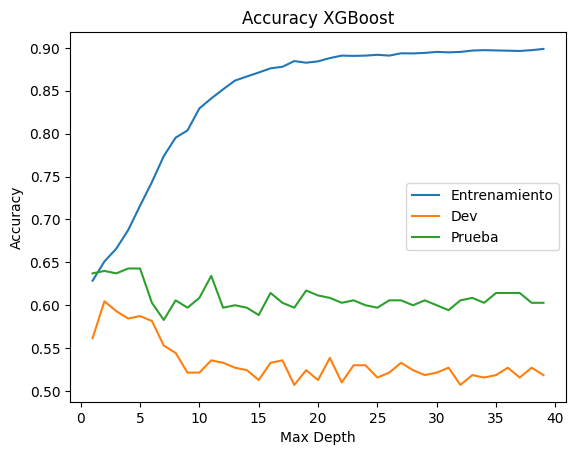

In [ ]:
plt.plot(range(1,40),acc_list_train,label="Entrenamiento")
plt.plot(range(1,40),acc_list_dev,label="Dev")
plt.plot(range(1,40),acc_list_test,label="Prueba")
plt.title("Accuracy XGBoost")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
acc_list_test = np.array(acc_list_test)

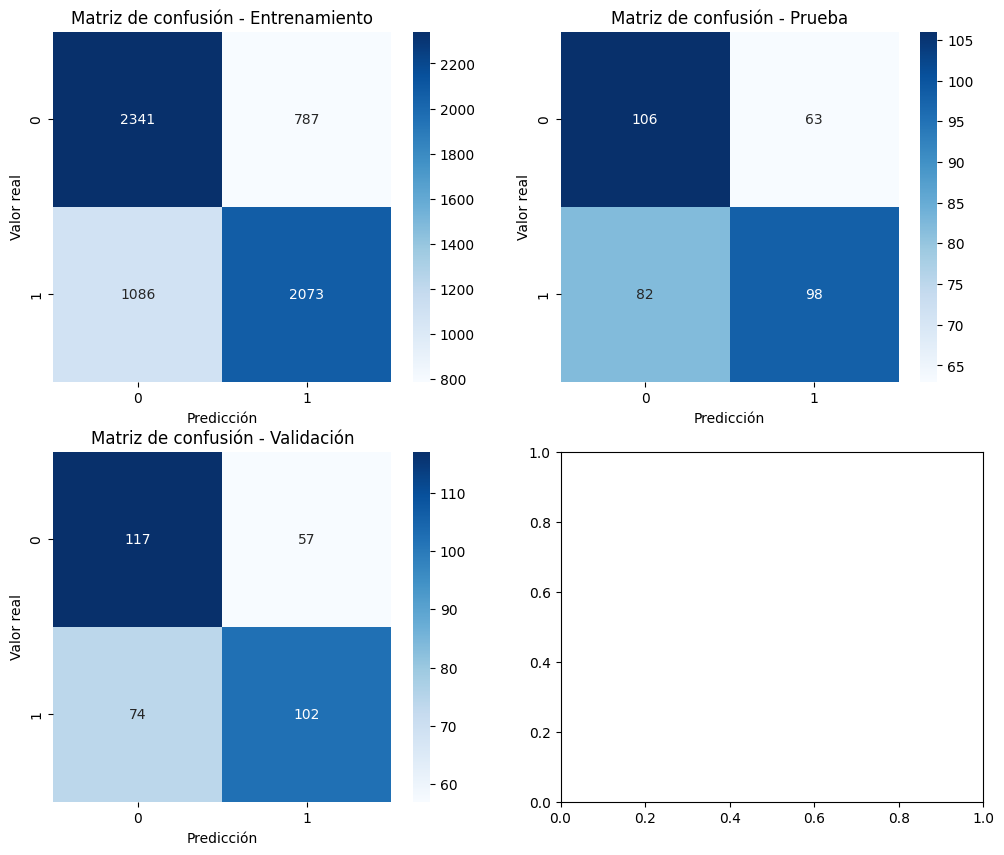

In [ ]:
model = XGBClassifier(max_depth=acc_list_test.argmax()+1)
model.fit(X_train, y_train)

y_dev_pred = model.predict(X_dev)
y_test_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

confussion_matrix_multiplot()

## Paso 11. Redes Neuronales

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled,y,test_size=0.33,random_state=1234)

In [ ]:
# Otpmizador Adam
optimizer = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

# Consturcción del modelo
model = keras.models.Sequential()
# Primera capa de las 8 características, primera capa oculta con 50 neuronas y función relu.
model.add(keras.layers.Dense(units=50,activation='relu',
                             input_dim=X_train.shape[1]))
# Segunda capa culta con 40 nueronas y función de activación relu
model.add(keras.layers.Dense(units=40,activation='relu'))
# # Capa de salida de una neruona y función de activación sigmoid
model.add(keras.layers.Dense(units=1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=[keras.metrics.AUC(name='auc')])

model.summary()

model.fit(X_train,y_train,epochs=500,verbose=2,validation_data=(X_valid,y_valid),batch_size=65)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │             300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           2,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,381 (9.30 KB)

 Trainable params: 2,381 (9.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
72/72 - 2s - 29ms/step - auc: 0.6438 - loss: 0.6600 - val_auc: 0.6555 - val_loss: 0.6678
Epoch 2/500
72/72 - 0s - 5ms/step - auc: 0.6570 - loss: 0.6527 - val_auc: 0.6636 - val_loss: 0.6510
Epoch 3/500
72/72 - 0s - 4ms/step - auc: 0.6579 - loss: 0.6519 - val_auc: 0.6563 - val_loss: 0.6533
Epoch 4/500
72/72 - 0s - 4ms/step - auc: 0.6611 - loss: 0.6490 - val_auc: 0.6590 - val_loss: 0.6524
Epoch 5/500
72/72 - 0s - 4ms/step - auc: 0.6687 - loss: 0.6468 - val_auc: 0.6570 - val_loss: 0.6532
Epoch 6/500
72/72 - 0s - 5ms/step - auc: 0.6645 - loss: 0.6477 - val_auc: 0.6603 - val_loss: 0.6547
Epoch 7/500
72/72 - 1s - 9ms/step - auc: 0.6643 - loss: 0.6467 - val_auc: 0.6630 - val_loss: 0.6491
Epoch 8/500
72/72 - 1s - 9ms/step - auc: 0.6670 - loss: 0.6467 - val_auc: 0.6625 - val_loss: 0.6499
Epoch 9/500
72/72 - 1s - 8ms/step - auc: 0.6686 - loss: 0.6451 - val_auc: 0.6622 - val_loss: 0.6510
Epoch 10/500
72/72 - 1s - 9ms/step - auc: 0.6709 - loss: 0.6434 - val_auc: 0.6658 - val_loss: 0.646

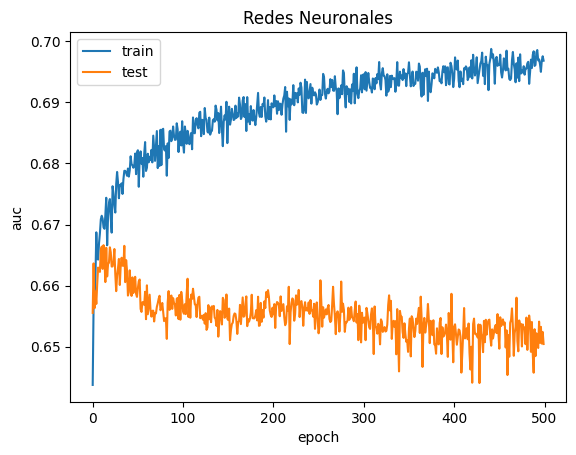

In [ ]:
plt.plot(model.history.history['auc'])
plt.plot(model.history.history['val_auc'])
plt.title('Redes Neuronales')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()